# Separable-PINN for 2D Laplace equation

- https://github.com/stnamjef/SPINN
- https://github.com/maximbeekenkamp/SPINNs

In [ ]:
import os
import time
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
from tqdm import trange

import jax
import jax.numpy as jnp
from jax import jvp, value_and_grad
import optax
from flax import linen as nn

In [ ]:
x = jnp.array([[1., 2.], [3., 4.], [5., 6.]])
y = jnp.array([[1., 2.], [1., 2.], [1., 2.]])
print(x.shape)
print(x)
print(y.shape)
print(y)
xy = jnp.einsum('fx, fy->fxy', x, y)
print(xy.shape)
print(xy)
z = jnp.array([[1., 2.], [3., 4.], [5., 6.]])
print(z.shape)
print(z)
xyz = jnp.einsum('fxy, fz->xyz', xy, z)
print(xyz.shape)
print(xyz)

(3, 2)
[[1. 2.]
 [3. 4.]
 [5. 6.]]
(3, 2)
[[1. 2.]
 [1. 2.]
 [1. 2.]]
(3, 2, 2)
[[[ 1.  2.]
  [ 2.  4.]]

 [[ 3.  6.]
  [ 4.  8.]]

 [[ 5. 10.]
  [ 6. 12.]]]
(3, 2)
[[1. 2.]
 [3. 4.]
 [5. 6.]]
(2, 2, 2)
[[[ 35.  44.]
  [ 70.  88.]]

 [[ 44.  56.]
  [ 88. 112.]]]


In [ ]:
x = jnp.array([[1., 2.], [3., 4.], [5., 6.]])
y = jnp.array([[1., 2.], [1., 2.], [1., 2.]])
print(x.shape)
print(x)
print(y.shape)
print(y)
xy = jnp.einsum('fx, fy->fxy', x, y)
print(xy.shape)
print(xy)
z = jnp.array([[1., 2.], [3., 4.], [5., 6.]])
print(z.shape)
print(z)
xyz = jnp.einsum('fxy, fz->xyz', xy, z)
print(xyz.shape)
print(xyz)

(3, 2)
[[1. 2.]
 [3. 4.]
 [5. 6.]]
(3, 2)
[[1. 2.]
 [1. 2.]
 [1. 2.]]
(3, 2, 2)
[[[ 1.  2.]
  [ 2.  4.]]

 [[ 3.  6.]
  [ 4.  8.]]

 [[ 5. 10.]
  [ 6. 12.]]]
(3, 2)
[[1. 2.]
 [3. 4.]
 [5. 6.]]
(2, 2, 2)
[[[ 35.  44.]
  [ 70.  88.]]

 [[ 44.  56.]
  [ 88. 112.]]]


In [ ]:
NC = 64
NI = 64
NB = 64
NC_TEST = 100
SEED = 444
LR = 1e-3
EPOCHS = 50000
N_LAYERS = 4
FEATURES = 64
LOG_ITER = 25000

In [ ]:
class SPINN(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x, y):
        inputs, outputs = [x, y], []
        init = nn.initializers.glorot_normal()
        for X in inputs:
            for fs in self.features[:-1]:
                X = nn.Dense(fs, kernel_init=init)(X)
                X = nn.activation.tanh(X)
            X = nn.Dense(self.features[-1], kernel_init=init)(X)
            outputs += [jnp.transpose(X, (1,0))]
        xy = jnp.einsum('fx, fy->xy', outputs[0], outputs[1])
        return xy
    
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

In [ ]:
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
feat_sizes = tuple(FEATURES for _ in range(N_LAYERS))
model = SPINN(feat_sizes)
apply_fn = jax.jit(model.apply)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)))
optim = optax.adam(LR)
state = optim.init(params)

In [ ]:
a = 9.
b = 3.

In [ ]:
def plot_u(xt_m, yt_m, u):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.scatter(xt_m, yt_m, c=u, cmap='seismic')

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xt_m, yt_m, c=u, cmap='seismic')

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xt_m, yt_m, u)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.contourf(xt_m, yt_m, u, cmap='seismic')

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xt_m, yt_m, u, cmap='seismic')

In [ ]:
def _exact_solution(x, y):
    return (jnp.sin(x) * jnp.sinh(y)) / (jnp.sin(a) * jnp.sinh(b))

def test_data_generator(nc_test):
    xt = jnp.linspace(0, a, nc_test).reshape(-1, 1)
    yt = jnp.linspace(0, b, nc_test).reshape(-1, 1)
    xt = jax.lax.stop_gradient(xt)
    yt = jax.lax.stop_gradient(yt)
    
    xt_m, yt_m = jnp.meshgrid(xt.ravel(), yt.ravel(), indexing='ij')
    u_gt = _exact_solution(xt_m, yt_m)
    return xt, yt, xt_m, yt_m, u_gt 

In [ ]:
xt, yt, xt_m, yt_m, u_gt = test_data_generator(NC_TEST)

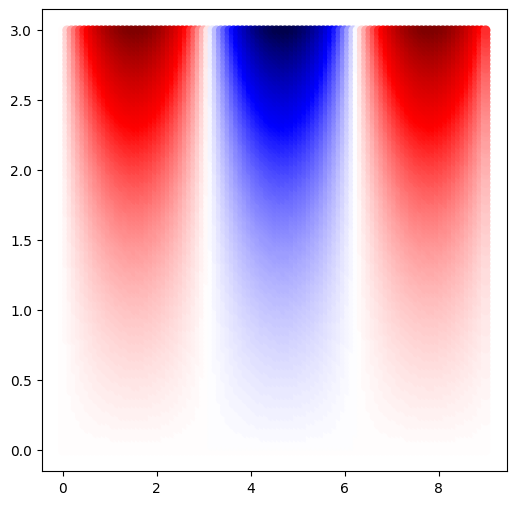

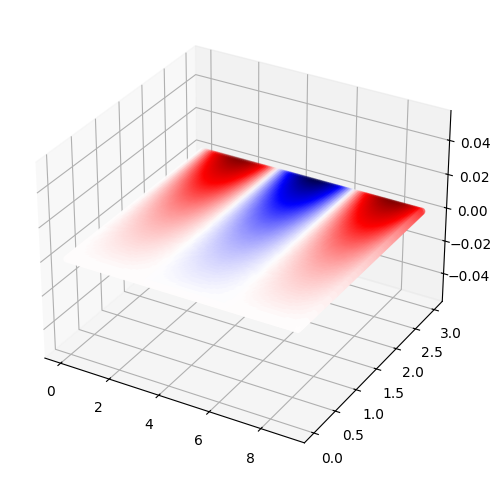

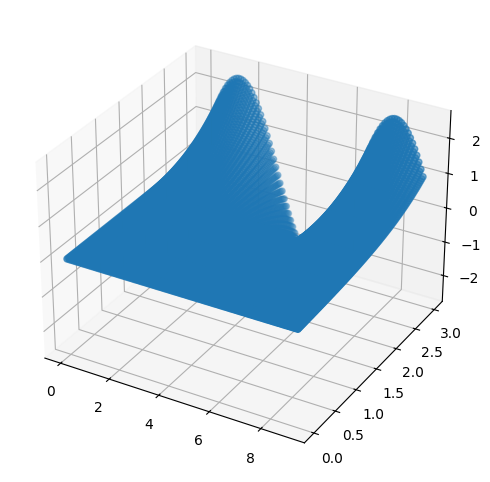

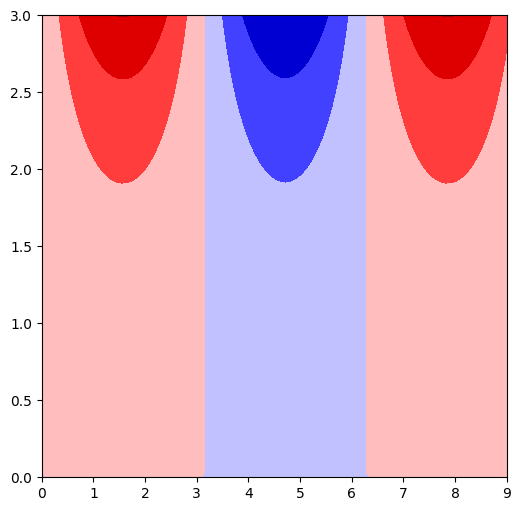

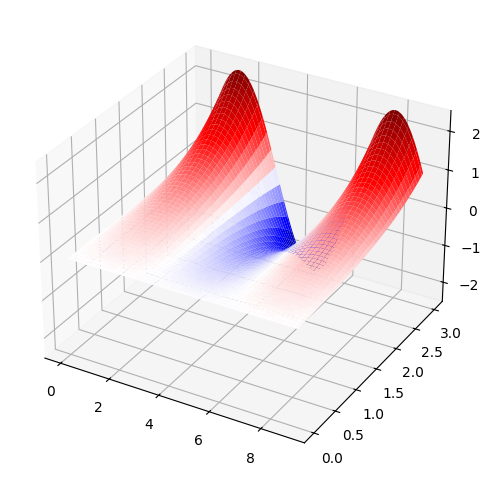

In [ ]:
plot_u(xt_m, yt_m, u_gt)

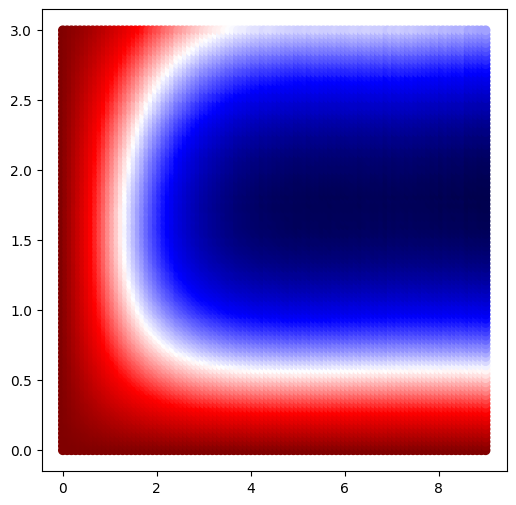

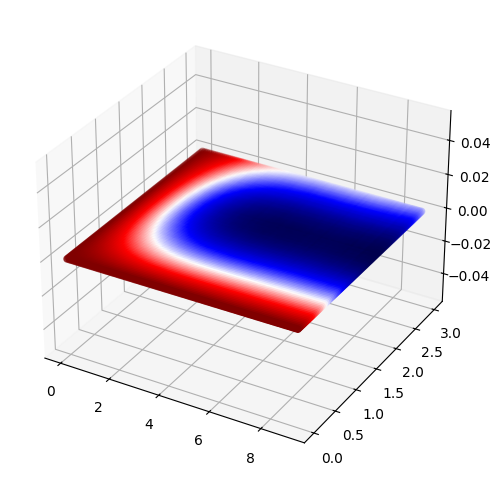

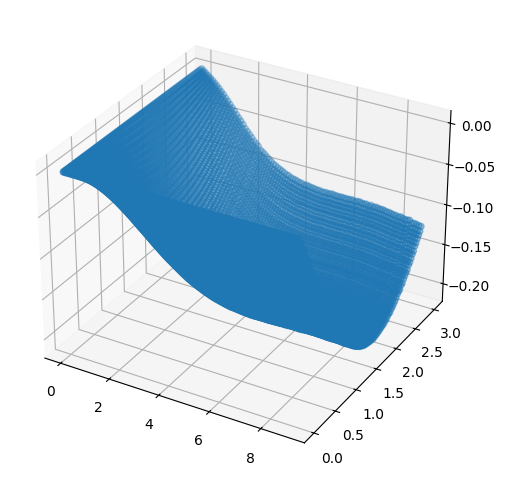

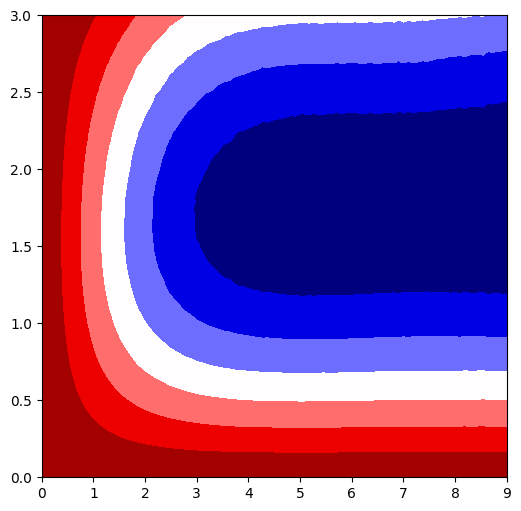

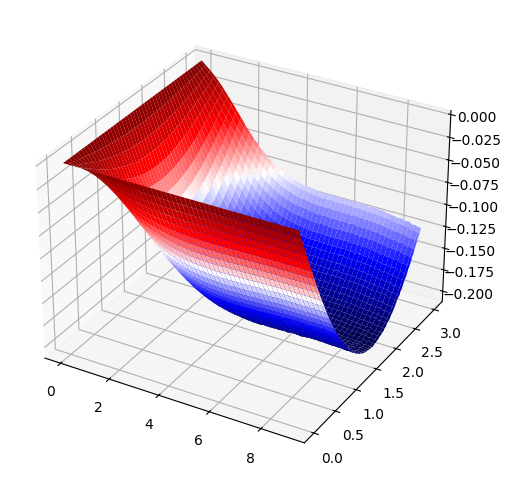

In [ ]:
u = apply_fn(params, xt, yt)
plot_u(xt_m, yt_m, u)

In [ ]:
def train_data_generator(nc, key):
    keys = jax.random.split(key, 2)

    xc = jax.random.uniform(keys[0], (nc, 1), minval=0., maxval=a)
    yc = jax.random.uniform(keys[0], (nc, 1), minval=0., maxval=b)
    xc_m, yc_m = jnp.meshgrid(xc.ravel(), yc.ravel(), indexing='ij')
    uc = jnp.zeros(xc_m.shape)
    
    xb = [jnp.array([[0.]]),
          jnp.array([[a]]),
          xc,
          xc]
    yb = [yc,
          yc,
          jnp.array([[0.]]),
          jnp.array([[b]])]
    xb_m0, yb_m0 = jnp.meshgrid(xb[0].ravel(), yb[0].ravel(), indexing='ij')
    xb_m1, yb_m1 = jnp.meshgrid(xb[1].ravel(), yb[1].ravel(), indexing='ij')
    xb_m2, yb_m2 = jnp.meshgrid(xb[2].ravel(), yb[2].ravel(), indexing='ij')
    xb_m3, yb_m3 = jnp.meshgrid(xb[3].ravel(), yb[3].ravel(), indexing='ij')

    ub = []
    ub += [jnp.zeros(xb_m0.shape)]
    ub += [jnp.sinh(yb_m1)/jnp.sinh(b)]
    ub += [jnp.zeros(xb_m2.shape)]
    ub += [jnp.sin(xb_m3)/jnp.sin(a)]

    return xc, yc, uc, xb, yb, ub

In [ ]:
key, subkey = jax.random.split(key, 2)
train_data = train_data_generator(NC, subkey)

In [ ]:
def hvp_fwdfwd(f, primals, tangents):
    g = lambda primals: jvp(f, (primals,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    return tangents_out

In [ ]:
def loss(apply_fn, *train_data):
    def residual_loss(params, x, y, source_term):
        u = apply_fn(params, x, y)
        v = jnp.ones(x.shape)
        uxx = hvp_fwdfwd(lambda x: apply_fn(params, x, y), (x,), (v,))
        uyy = hvp_fwdfwd(lambda y: apply_fn(params, x, y), (y,), (v,))
        return jnp.mean((uxx + uyy - source_term)**2)
    
    def boundary_loss(params, x, y, u):
        loss = 0.
        for i in range(4):
            loss += (1/4.) * jnp.mean((apply_fn(params, x[i], y[i]) - u[i])**2)
        return loss
    
    xc, yc, uc, xb, yb, ub = train_data

    fn = lambda params: residual_loss(params, xc, yc, uc) + \
                        boundary_loss(params, xb, yb, ub)
    return fn

In [ ]:
loss_fn = loss(apply_fn, *train_data)

In [ ]:
@jax.jit
def train_one_step(params, state):
    loss, gradient = value_and_grad(loss_fn)(params)
    params, state = update_model(optim, gradient, params, state)
    return loss, params, state

In [ ]:
def relative_l2(u, u_gt):
    return jnp.linalg.norm(u-u_gt) / jnp.linalg.norm(u_gt)

In [ ]:
xt, yt, xt_m, yt_m, u_gt = test_data_generator(NC_TEST)

In [ ]:
start = time.time()
for e in trange(1, EPOCHS+1):
    loss, params, state = train_one_step(params, state)
    if e % LOG_ITER == 0:
        ut = apply_fn(params, xt, yt)
        error = relative_l2(ut, u_gt)
        print(f'Epoch: {e}/{EPOCHS} --> loss: {loss:.8f}, error: {error:.8f}')
end = time.time()
print(f'Runtime: {((end-start)/EPOCHS*1000):.2f} ms/iter.')

 51%|█████     | 25432/50000 [00:14<00:12, 2027.02it/s]

Epoch: 25000/50000 --> loss: 0.00016973, error: 0.01167296


100%|██████████| 50000/50000 [00:24<00:00, 2026.91it/s]

Epoch: 50000/50000 --> loss: 0.00000410, error: 0.00356606
Runtime: 0.49 ms/iter.


In [ ]:
xt, yt, xt_m, yt_m, u_gt = test_data_generator(NC_TEST)

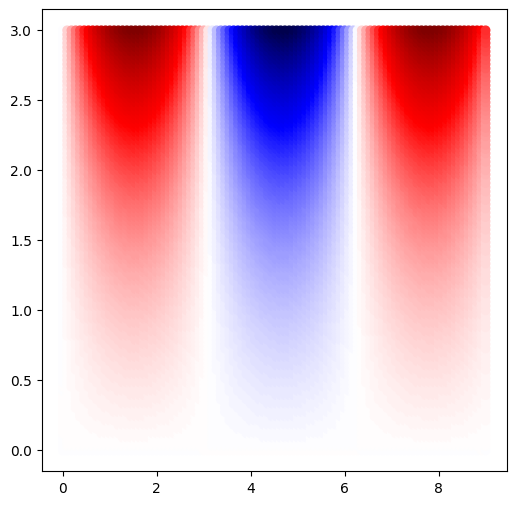

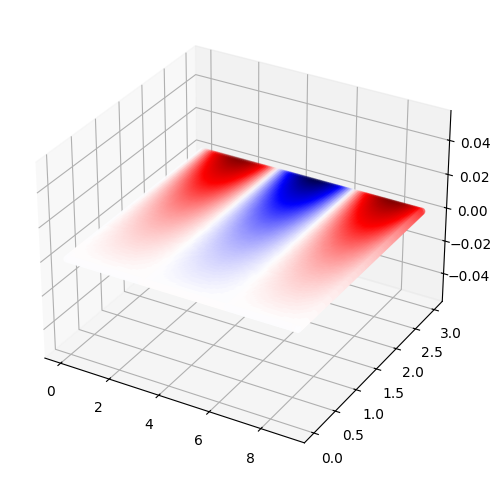

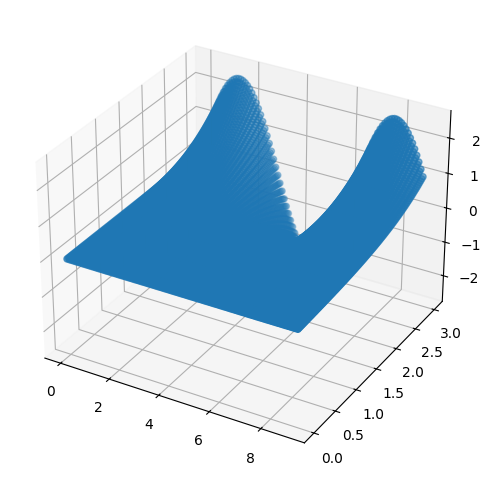

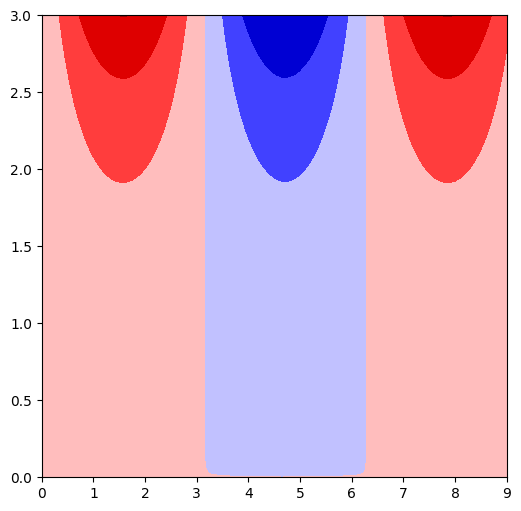

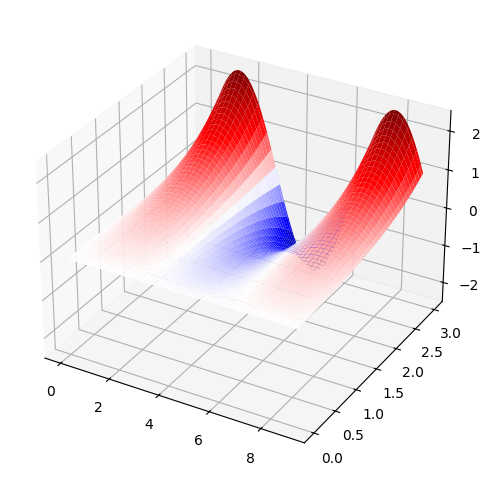

In [ ]:
u = apply_fn(params, xt, yt)
plot_u(xt_m, yt_m, u)